# Art generating GAN

A Generative Adversarial Network for generating new art

# Import required libraries

In [ ]:
import os

# Keras functions
import tensorflow as tf
import keras
from keras.optimizers import *
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Dropout, LeakyReLU, BatchNormalization
from keras.layers import Activation, ZeroPadding2D, UpSampling2D
from keras.layers import Input, Reshape
from matplotlib import pyplot
from IPython.display import clear_output

# Numpy functions
import numpy
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy import zeros
from numpy import ones
from numpy import asarray

#Torchvision for fast and easy loading and resizing
import torchvision
import torchvision.transforms as transforms

from PIL import Image


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#cd drive/MyDrive/GAN_art/GANGogh
%cd '/content/drive/MyDrive/Project/GAN_art/GANGogh'

/content/drive/.shortcut-targets-by-id/1w8pQAn4l8zm_dSWvO74UiSw2PGeVsyC4/GAN_art/GANGogh


In [ ]:
ls

archive.zip     images.zip  monet_jpg.zip   tflib/
best_artworks/  misc/       README.md       training_data.npy
GANgogh.py      monet_jpg/  small_dataset/


In [ ]:
'''
import zipfile
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('best_artworks/')
'''

"\nimport zipfile\nwith zipfile.ZipFile('archive.zip', 'r') as zip_ref:\n    zip_ref.extractall('best_artworks/')\n"

# Load and pre-process the data

In [ ]:
dataset_path = "best_artworks/resized/"
#dataset_path = "/content/drive/Shareddrives/Disk1/WGANs art/GANGogh/images/figurative/"
#dataset_path = "./images/figurative/"
saved_path = 'training_data.npy'

WIDTH = 64
HEIGHT = 64
IMG_SIZE = (WIDTH,HEIGHT)
EPOCHS = 250

#Look for saved file to save time loading and processing images between runs
print("Looking for previously saved file...")

if not os.path.isfile(saved_path):

    print("\n File not found, loading new data...\n")
    dataset = []
    transform_ds = transforms.Compose([transforms.Resize(IMG_SIZE),]) #define transformation
    
    image_folder = torchvision.datasets.ImageFolder(root=dataset_path,
                                     transform=transform_ds)

    print('Number of artworks found: ',len(image_folder))
    
    
    print("Converting images, this will take a few minutes")
    for i in range (len(image_folder)):
        image_array = numpy.array(image_folder[i][0])
        dataset.append(image_array)
        if (i%500 == 0):
            print("Pictures processed: ", i)
            
    print("Saving dataset binary file...")
    dataset = np.array(dataset, dtype=np.float32)
    dataset = (dataset - 127.5) / 127.5 #Normalize to [-1 , 1]
    numpy.save(saved_path, dataset)  #Save processed images as npy file

else:
    print("Data found, loading..")
    dataset = np.load(saved_path) 

print("Dataset length: ", len(dataset))

Looking for previously saved file...
Data found, loading..
Dataset length:  8683


Confirm that the images are the correct shape.

In [ ]:
dataset[3].shape

(64, 64, 3)

In [ ]:
#Use a TensorFlow Dataset to manage the images for easy shuffling, dividing etc
BATCH_SIZE = 32

training_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(9000).batch(BATCH_SIZE)

# Explore the data

Here, we'll check out the dataset and what it looks like

In [ ]:
import pandas as pd

artists = pd.read_csv('best_artworks/artists.csv')
artists

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194
5,5,Salvador Dali,1904 - 1989,Surrealism,Spanish,Salvador Domingo Felipe Jacinto Dalí i Domènec...,http://en.wikipedia.org/wiki/Salvador_Dalí,139
6,6,Edouard Manet,1832 - 1883,"Realism,Impressionism",French,Édouard Manet (US: ; UK: ; French: [edwaʁ manɛ...,http://en.wikipedia.org/wiki/Édouard_Manet,90
7,7,Andrei Rublev,1360 - 1430,Byzantine Art,Russian,"Andrei Rublev (Russian: Андре́й Рублёв, IPA: [...",http://en.wikipedia.org/wiki/Andrei_Rublev,99
8,8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877
9,9,Gustav Klimt,1862 - 1918,"Symbolism,Art Nouveau",Austrian,"Gustav Klimt (July 14, 1862 – February 6, 1918...",http://en.wikipedia.org/wiki/Gustav_Klimt,117


There's some data that we dont really need for this task, like their nationality, wikipedia page and bio. Below, we filter the data to more clearly see the artists along with their corresponding genre and number of paintings in a more compact manner. As you can see, we have quite the mix of genres which will hopefully give our model a good base to generate from.

In [ ]:
artists[['name','genre','paintings']]

,name,genre,paintings
0,Amedeo Modigliani,Expressionism,193
1,Vasiliy Kandinskiy,"Expressionism,Abstractionism",88
2,Diego Rivera,"Social Realism,Muralism",70
3,Claude Monet,Impressionism,73
4,Rene Magritte,"Surrealism,Impressionism",194
5,Salvador Dali,Surrealism,139
6,Edouard Manet,"Realism,Impressionism",90
7,Andrei Rublev,Byzantine Art,99
8,Vincent van Gogh,Post-Impressionism,877
9,Gustav Klimt,"Symbolism,Art Nouveau",117


Here we can check out the top 5 genres and artists

In [ ]:
top_genres = artists['genre'].value_counts()
top_genres[:5]

Baroque                 4
Impressionism           4
Post-Impressionism      4
Northern Renaissance    4
Romanticism             3
Name: genre, dtype: int64

****Note: These genres are only sorted from the number of artists belonging to that genre, not the number of paintings.****

We'll sort the list of artists by number of paintings instead to get a better overview of which artist has the most painings in the dataset.

In [ ]:
no_of_paintings = artists[['name','paintings','genre']].sort_values(ascending=False, by='paintings')
no_of_paintings

,name,paintings,genre
8,Vincent van Gogh,877,Post-Impressionism
30,Edgar Degas,702,Impressionism
13,Pablo Picasso,439,Cubism
15,Pierre-Auguste Renoir,336,Impressionism
19,Albrecht Dürer,328,Northern Renaissance
46,Paul Gauguin,311,"Symbolism,Post-Impressionism"
16,Francisco Goya,291,Romanticism
31,Rembrandt,262,Baroque
20,Alfred Sisley,259,Impressionism
32,Titian,255,"High Renaissance,Mannerism"


Van Gogh has been busy I see! Lets try printing some of the paintings to see what we're dealing with.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

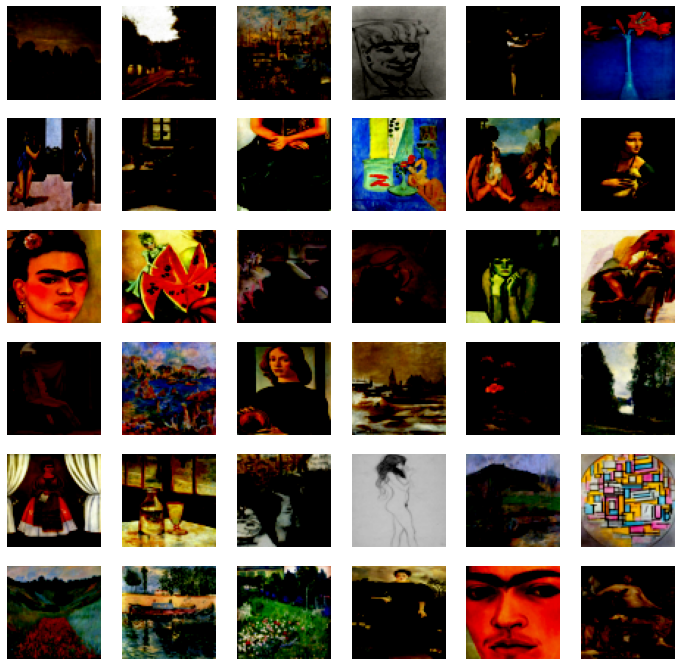

In [ ]:
import matplotlib.pyplot as plt
import random

np.random.shuffle(dataset) #Shuffle the images

fig = plt.figure(figsize=(12,12))
for i in range(1,37):
    fig.add_subplot(6,6,i)
    plt.imshow(dataset[i])
    plt.axis('off')

**Beautiful!**
There's some distortion from the rescaling and they look all weird normalized, this is due to plt.imshow only displaying ranges [0,1] and these are normalized to [-1,1] . If we were to not normalize them at the beginning they would look normal.

# Build the models

The generator will take in a random seed and generate an image from that seed, upsampling as much as needed. Note that increasing resolution will require retuning of the models as well as increase training time by a lot. I found that the generator needs to have quite a lot of capacity in order to keep up with the discriminator at later stages of training.

architecture based on the findings and guidelines proposed in the paper:

* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
* Use batchnorm in both the generator and the discriminator.
* Remove fully connected hidden layers for deeper architectures
* Use ReLU activation in generator for all layers except for the output, which uses Tanh.
* Use LeakyReLU activation in the discriminator for all layers.

Further increasing conv layers will lead to mode collapse from what I've tried

In [ ]:
def build_generator(seed_size, channels):
    
    model = Sequential()

    model.add(Dense(64*64,activation="relu",input_dim=seed_size)) #64x64 units
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Optional additional upsampling goes here
    model.add(UpSampling2D(size = (2,2))) #4,4 for 128x128, 2,2 for 64x64
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))
    
    return model



The discriminator is simply a CNN based image classifier which will output values of what it thinks is fake or real with 0 being fake and 1 being real

In [ ]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

Here we use the untrained generator to generate an image (which will be very random)

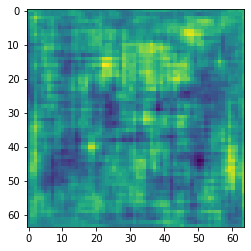

In [ ]:
SEED_SIZE = 100
IMAGE_CHANNELS = 3

generator = build_generator(SEED_SIZE,IMAGE_CHANNELS)

noise = tf.random.normal([1,SEED_SIZE])
generated_image = generator(noise,training=False)

plt.imshow(generated_image[0, :, :, 0])

Classify this random image with the untrained discriminator, the prediction will likely be 50%

In [ ]:
image_shape = (HEIGHT, HEIGHT, IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.5000043]], shape=(1, 1), dtype=float32)


# Define loss functions for the models

**The discriminators loss** is based on its ability to distinguish real images from fakes. It compares its predictions on real images to an array of ones (remember 1 being real) and its predictions on fake images to an array of zeros (0 being fake). The goal is to classify all real images as 1 and all fakes as 0. The total loss is then these two losses added together.

**The generators loss** is a measurement of how good it performed at fooling the discriminator. If the discriminator classifies the fake images as 1, the generator did a good job.


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The two models optimizers are separated because we train them separately. I found a slightly lower generator LR to be beneficial.

Beta value of 0.5 generated more stable models as per the findings in the paper "Unsupervised representation learning with deep convolutional generative adversarial networks"

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1.2e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5)

# Function for saving the generated images

In [ ]:
GENERATED_ROWS = 7
GENERATED_COLS = 7
MARGIN = 2 # Give the images a little frame

def save_images(cnt, noise):
    #Define the "base" of the saved image as a big black canvas
    image_array = np.full(( 
      MARGIN + (GENERATED_ROWS * (WIDTH + MARGIN)), 
      MARGIN + (GENERATED_COLS * (HEIGHT + MARGIN)), 3), 
      0, dtype=np.uint8)
    
    generated_images =  generator.predict(noise)
    
    image_count = 0
    for row in range(GENERATED_ROWS):
        for col in range(GENERATED_COLS):
            r = row * (WIDTH + 2) + MARGIN
            c = col * (HEIGHT + 2) + MARGIN
            image_array[r:r+WIDTH , c:c+HEIGHT] = generated_images[image_count] * 127.5 + 127.5
            image_count += 1
            
    output_path  = os.path.join("/kaggle/working/generated2/")
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    filename = os.path.join(output_path,f"train-{cnt}.png")
    im = Image.fromarray(image_array)
    im.save(filename)

# Train the models

The training begins by providing a random seed to the generator, which is then used to generate an image. The discriminator then classifies images from both the fake and real dataset. The loss is calculated separately for each model and the gradients are updated.

Based on the TensorFlow DCGAN tutorial

In [ ]:
# This goes a bit deeper "behind the scenes" and manually sets the gradients
# instead of letting Keras and TensorFlow set it automatically. This is because
# the two models need to be trained separately
@tf.function
def train_step(images):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(seed, training = True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        
        gradients_of_generator = gen_tape.gradient(
            gen_loss,
            generator.trainable_variables
        )
        gradients_of_discriminator = disc_tape.gradient(
            disc_loss, 
            discriminator.trainable_variables
        )
        
        generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                                generator.trainable_variables))
        
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, 
                                                    discriminator.trainable_variables))
        
        return gen_loss, disc_loss

In [ ]:

def train(dataset, epochs):
    # Use a fixed seed for the saved images so we can watch their development
    fixed_seed = np.random.normal(0, 1, (GENERATED_ROWS * GENERATED_COLS, SEED_SIZE))
    
    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []
        
        for image_batch in dataset:
            t = train_step(image_batch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])
            
        g_loss = sum(gen_loss_list) / len(gen_loss_list) #calculate losses
        d_loss = sum(disc_loss_list) / len(disc_loss_list)
        
        print(f'Epoch {epoch+1}, gen loss = {g_loss}, disc loss = {d_loss}')
        
        #save_images(epoch, fixed_seed)
        

Train the models, ideally we want to see the losses hovering at around the same values, indicating that they are both improving at similar rates

In [ ]:
train(training_dataset, EPOCHS)

Epoch 1, gen loss = 2.544487237930298, disc loss = 1.1053857803344727
Epoch 2, gen loss = 1.5938923358917236, disc loss = 1.4031634330749512
Epoch 3, gen loss = 1.5103330612182617, disc loss = 1.1804265975952148
Epoch 4, gen loss = 1.1445034742355347, disc loss = 1.455805778503418
Epoch 5, gen loss = 1.07248055934906, disc loss = 1.4469859600067139
Epoch 6, gen loss = 0.9633628726005554, disc loss = 1.469724178314209
Epoch 7, gen loss = 0.8746020793914795, disc loss = 1.5008203983306885
Epoch 8, gen loss = 0.9254072904586792, disc loss = 1.442288875579834
Epoch 9, gen loss = 0.8840543627738953, disc loss = 1.4451969861984253
Epoch 10, gen loss = 0.958236813545227, disc loss = 1.4271878004074097
Epoch 11, gen loss = 0.8929644823074341, disc loss = 1.4453834295272827
Epoch 12, gen loss = 1.0073330402374268, disc loss = 1.379812240600586
Epoch 13, gen loss = 0.9599524140357971, disc loss = 1.4042601585388184
Epoch 14, gen loss = 0.8672919869422913, disc loss = 1.4756274223327637
Epoch 15,

# Zip images for download

In [ ]:
#!zip -r images.zip "/kaggle/working/generated2/"

In [ ]:
#from IPython.display import FileLink
#FileLink(r'images.zip')

# Bonus: printing a random set of pictures generated by the trained generator

Just for playing with it to see what we find, generates a new seed everytime

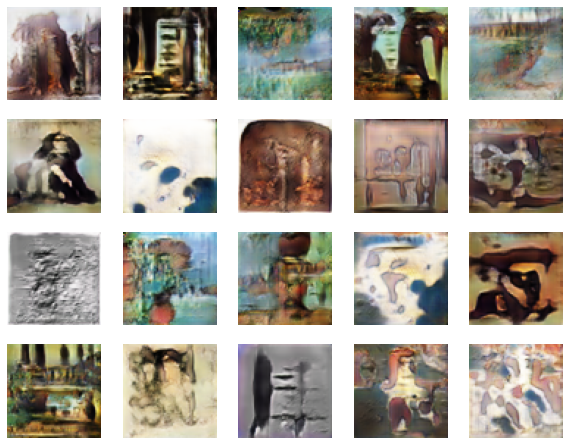

In [ ]:
seed2 = tf.random.normal([BATCH_SIZE, SEED_SIZE])
generated_images2 = generator(seed2, training = True)

generated_images2 =0.5 * generated_images2 + 0.5

fig = plt.figure(figsize=(10,10))
for i in range(1,21):
    fig.add_subplot(5,5,i)
    plt.imshow(generated_images2[i])
    plt.axis('off')